In [3]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
options(repr.matrix.max.rows = 6)

sessions<-read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

sessions_tidy<-sessions|>
     mutate(start_time=paste(start_time,":00"),
     end_time=paste(end_time,":00"),
     start_time=dmy_hms(start_time),
     end_time=dmy_hms(end_time),
     session_length=int_length(interval(start_time,end_time)))|>
     select(start_time,end_time,session_length)|>
     mutate(year_start=year(start_time),month_start=month(start_time),day_start=day(start_time),
     hour_start=hour(start_time),minute_start=minute(start_time),startwday=wday(start_time,label=TRUE,abbr=TRUE))|>
     mutate(year_end=year(end_time),month_end=month(end_time),day_end=day(end_time),
     hour_end=hour(end_time),minute_end=minute(end_time),endwday=wday(end_time,label=TRUE,abbr=TRUE))
head(sessions_tidy)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `end_time = dmy_hms(end_time)`.
Caused by warning:
!  2 failed to parse.”


start_time,end_time,session_length,year_start,month_start,day_start,hour_start,minute_start,startwday,year_end,month_end,day_end,hour_end,minute_end,endwday
<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<ord>,<dbl>,<dbl>,<int>,<int>,<int>,<ord>
2024-06-30 18:12:00,2024-06-30 18:24:00,720,2024,6,30,18,12,Sun,2024,6,30,18,24,Sun
2024-06-17 23:33:00,2024-06-17 23:46:00,780,2024,6,17,23,33,Mon,2024,6,17,23,46,Mon
2024-07-25 17:34:00,2024-07-25 17:57:00,1380,2024,7,25,17,34,Thu,2024,7,25,17,57,Thu
2024-07-25 03:22:00,2024-07-25 03:58:00,2160,2024,7,25,3,22,Thu,2024,7,25,3,58,Thu
2024-05-25 16:01:00,2024-05-25 16:12:00,660,2024,5,25,16,1,Sat,2024,5,25,16,12,Sat
2024-06-23 15:08:00,2024-06-23 17:10:00,7320,2024,6,23,15,8,Sun,2024,6,23,17,10,Sun


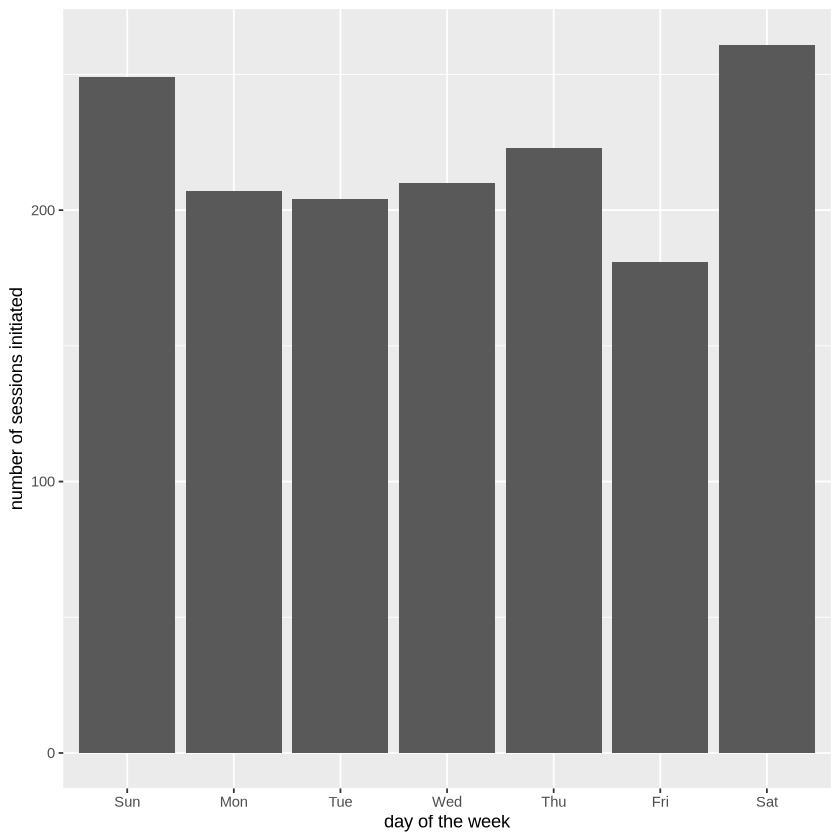

In [4]:
bydayofweek<-ggplot(sessions_tidy,aes(x=startwday))+
geom_bar()+
labs(x="day of the week",y="number of sessions initiated")
bydayofweek

Here, this graph shows that there were some trends in which day of the week had the highest plays. Interestingly, there were less sessions started on Friday compared to any other day. This graph shows that the weekends had higher playership, which is expected since eople usually have more free time on the weekends.

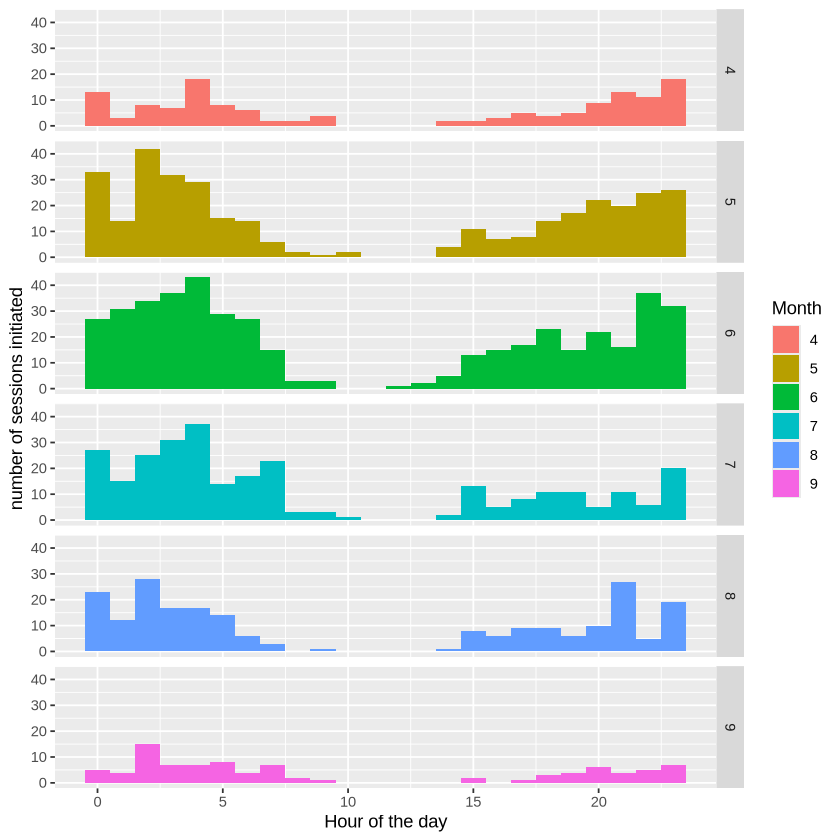

In [5]:
#this one needs to be redone to compensate for the potential lack of data in september
byhour<-ggplot(sessions_tidy,aes(x=hour_start,fill=as_factor(month_start)))+
geom_histogram(bins=24)+
facet_grid(rows = vars(month_start))+
labs(x="Hour of the day",y="number of sessions initiated",fill="Month")
byhour

Here we can see that most sessions are initated around 10pm to 5am. The month and time with the most sessions initiated was June at 5am. We can see that almost no sessions were initiated from 8am to 5pm. These were

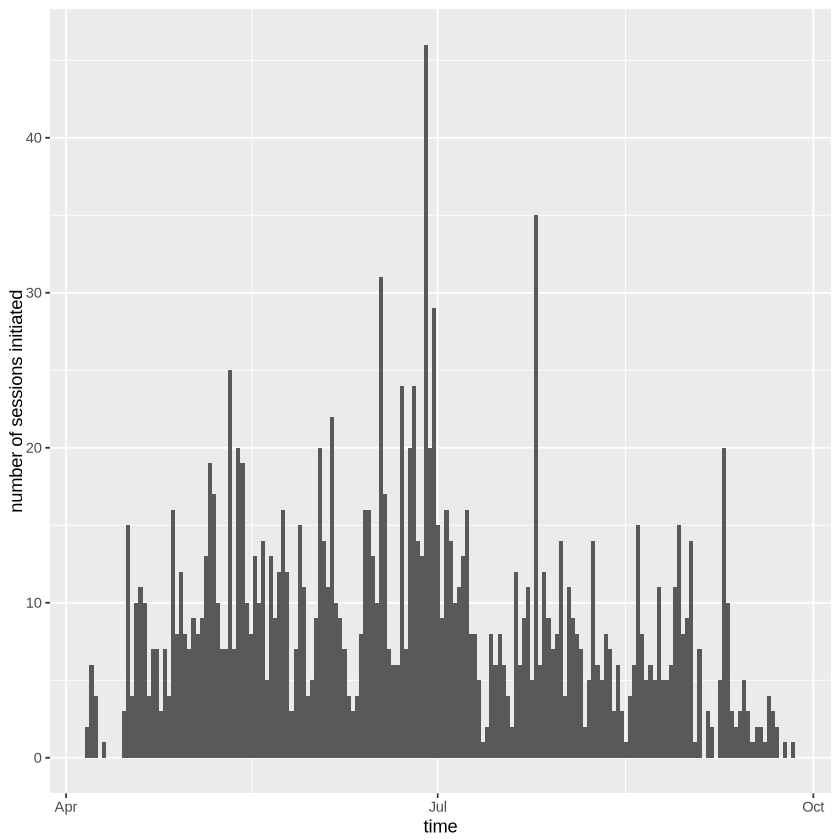

In [6]:
#Someone please find out how over how many days the data was collected and set that as the number of bins.
#first recorded day is April 6th, 2024, and the last is September 26th, 2024
over_time<-ggplot(sessions_tidy,aes(x=start_time))+
geom_histogram(bins=174)+
labs(x="time",y="number of sessions initiated")
over_time

peaked in june; need to summarise and find max. what do spikes represent?

Warning message:
“Removed 475 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_bar()`).”


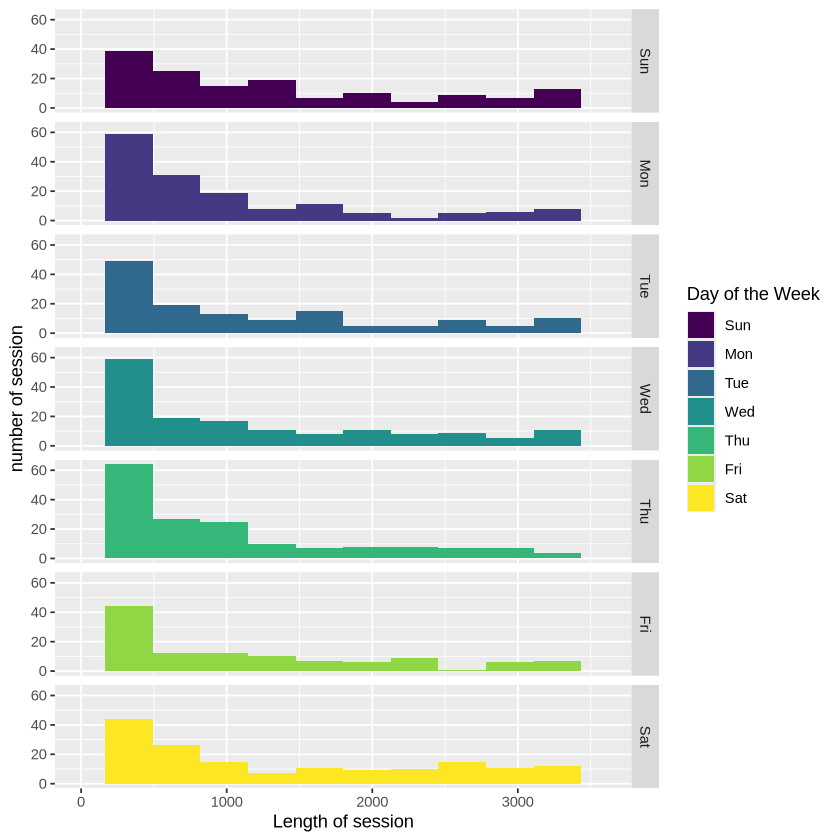

In [7]:
#may want to make this into a logarithmic scale without limits. 
#From this and the number of sessions, we can determine the possibility of having x amount of players on simultaneously.
#also, change to size to a larger, more readable size.
duration<-ggplot(sessions_tidy,aes(x=session_length,fill=startwday))+
geom_histogram(bins=12)+
facet_grid(rows = vars(startwday))+
labs(x="Length of session",y="number of session",fill="Day of the Week")+
xlim(c(0,3600))
duration

Yap session, how most sessions are shorter. Although many sessions that are initiated each hour, there may not , may not need that many licenses to handle that many players. 

In [ ]:
#potential ideas
#group by each day, and then look at which days had the most play time. 
#could cheack each minute to see how many people are on. this would be done by editing the initial session_tidy
#session_length column into two steps, one for the interval and one for the session length
#select all weekends and then graph the playership of the weekends over time.

start_time,end_time,session_length,year_start,month_start,day_start,hour_start,minute_start,startwday,dayofweek
<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<ord>,<dbl>
2024-06-30 18:12:00,2024-06-30 18:24:00,720,2024,6,30,18,12,Sun,7.758333
2024-06-17 23:33:00,2024-06-17 23:46:00,780,2024,6,17,23,33,Mon,1.981250
2024-07-25 17:34:00,2024-07-25 17:57:00,1380,2024,7,25,17,34,Thu,4.731944
2024-07-25 03:22:00,2024-07-25 03:58:00,2160,2024,7,25,3,22,Thu,4.140278
2024-05-25 16:01:00,2024-05-25 16:12:00,660,2024,5,25,16,1,Sat,6.667361
2024-06-23 15:08:00,2024-06-23 17:10:00,7320,2024,6,23,15,8,Sun,7.630556


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


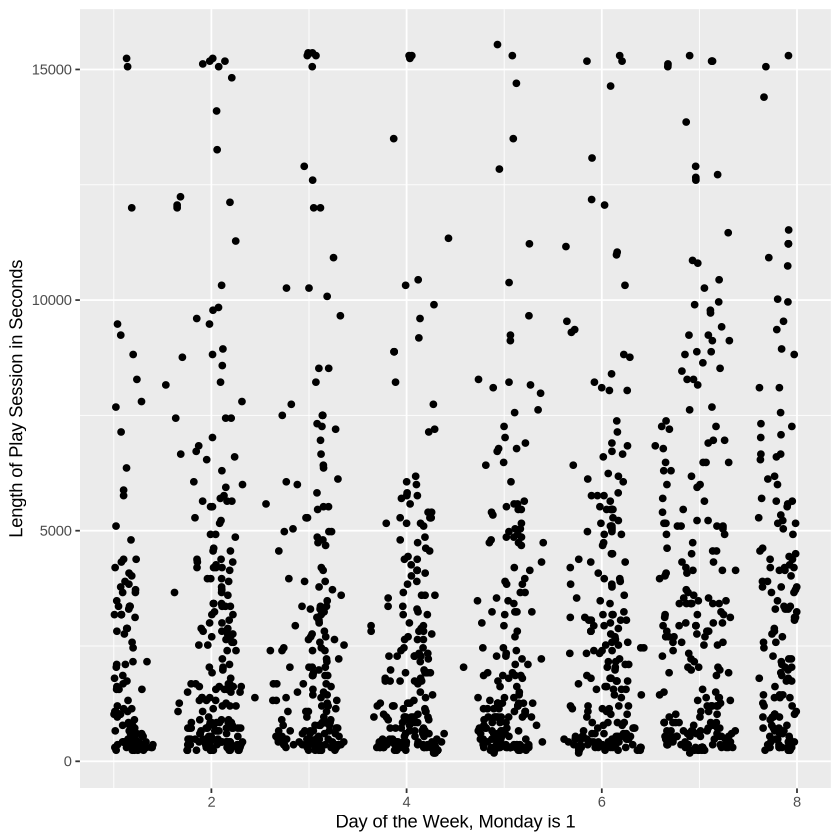

In [8]:
#concept: Change day of the week to a variable based on hour and minute
session_scale_wday<-sessions_tidy|>
select(start_time:startwday)|>
mutate(dayofweek=wday(start_time,label=FALSE,week_start=1)+(minute_start/60+hour_start)/24)
head(session_scale_wday)
session_length_wday<-session_scale_wday|>
ggplot(aes(x=dayofweek,y=session_length))+
geom_point()+
labs(x="Day of the Week, Monday is 1",y="Length of Play Session in Seconds")
session_length_wday
#then do clustering on play time and day of the week

In [20]:
set.seed(2019)
clusnums<-tibble(num_clusters=1:20)
scaleday_recipe<-recipe(~dayofweek,data=session_scale_wday)|>
step_scale(all_predictors())|>
step_center(all_predictors())
wday_spec_tune <- k_means(num_clusters = tune()) |>
        set_engine("stats",nstart=10)
#3
elbow_stats <- workflow() |>
        add_recipe(scaleday_recipe) |>
        add_model(wday_spec_tune) |>
        tune_cluster(resamples = apparent(session_scale_wday), grid = clusnums) |>
        collect_metrics()|>
#4
        filter(.metric=="sse_within_total")|>
        mutate(total_WSSD=mean)|>
        select(num_clusters,total_WSSD)
elbow_stats

num_clusters,total_WSSD
<int>,<dbl>
1,1534.0000
2,364.6981
3,157.1809
⋮,⋮
18,2.539115
19,2.096135
20,2.122664


Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`).”


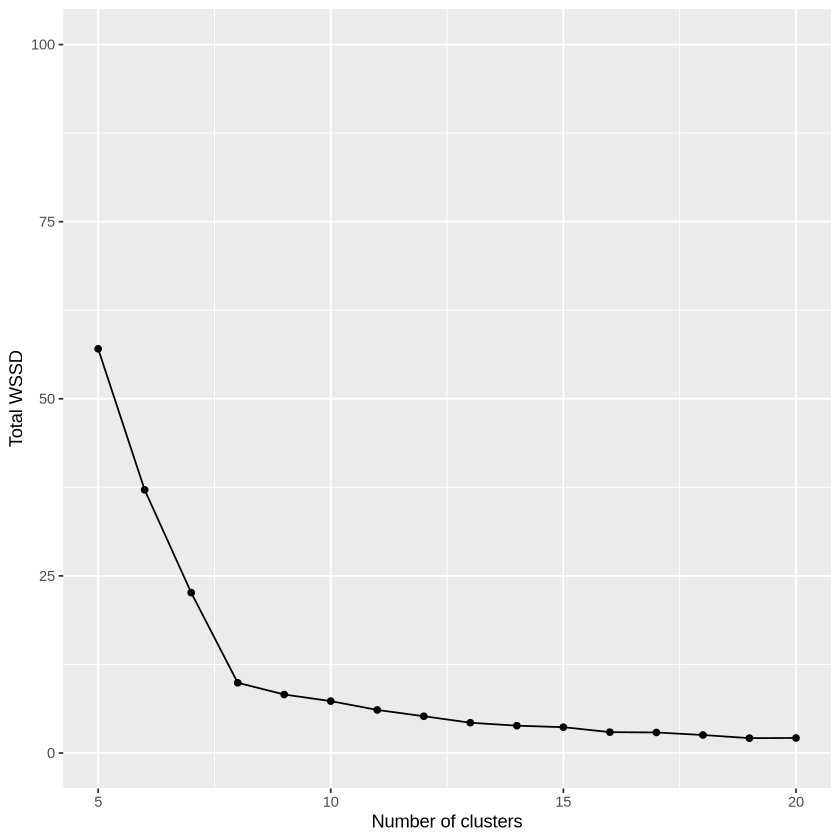

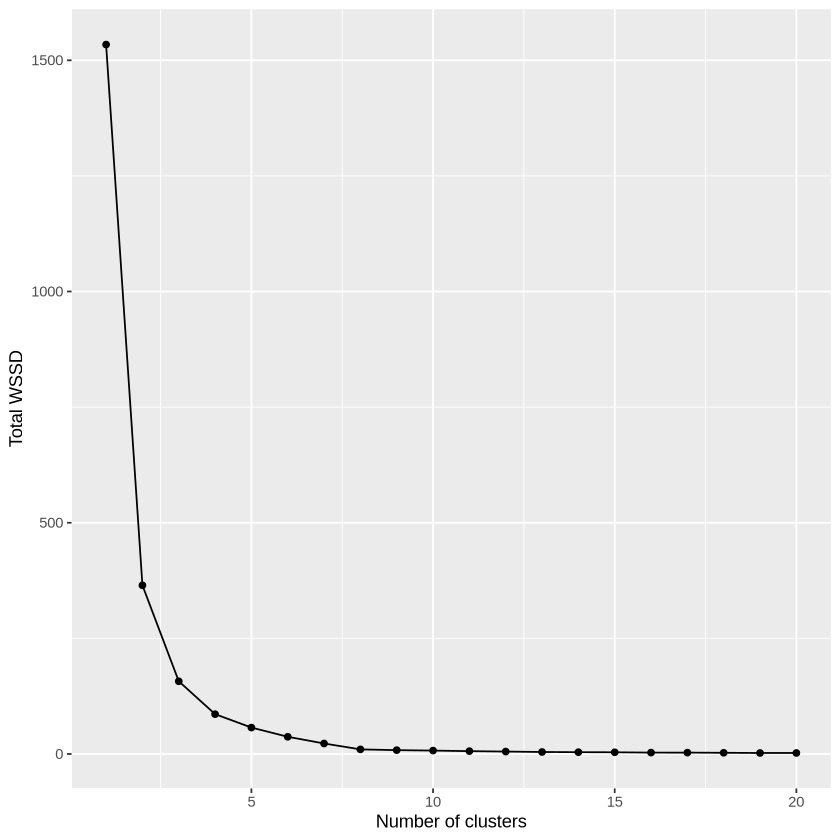

In [27]:
elbow_plot1<-ggplot(elbow_stats,aes(x=num_clusters,y=total_WSSD))+
geom_point()+
geom_line()+
labs(x="Number of clusters", y="Total WSSD")+
xlim(c(5,20))+
ylim(c(0,100))
# No Answer - remove if you provide an answer

elbow_plot2<-ggplot(elbow_stats,aes(x=num_clusters,y=total_WSSD))+
geom_point()+
geom_line()+
labs(x="Number of clusters", y="Total WSSD")
# No Answer - remove if you provide an answer
elbow_plot1
elbow_plot2